In [368]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import json
from pycocotools.coco import COCO
from pathlib import Path
import requests
from tqdm import tqdm
from threading import Thread
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## COCO Data

In [212]:
%matplotlib inline

In [3]:
def download_annotations(coco_dir,year=2017,annotation_type="instances"):
    """Downloads Coco training and validation annotations for given year and type.
    Inputs:
    coco_dir: Directory where data should be extracted. Will create an annotations
    folder if one doesn't already exists.
    year: should be either 2014 or 2017 depending on desired dataset.
    annotation_type: can be any of instances, keypoints or captions depending on task.
    Returns: PosixPath for training and validation annotation files.
    """
    if isinstance(coco_dir,str):
        coco_dir = Path(coco_dir)
     
    year = str(year)
    
    print("checking if annotations already exist...")
    
    annotation_dir = coco_dir/'annotations'
    if not annotation_dir.is_dir():
        annotation_dir.mkdir()
        print(f"{annotation_dir} directory not found, created it.")
    
    train_pth_exists = [s for s in annotation_dir.iterdir() if annotation_type+"_train"+year in str(s)]
    val_pth_exists = [s for s in annotation_dir.iterdir() if annotation_type+"_val"+year in str(s)]
    
    if len(train_pth_exists)>0 and len(val_pth_exists)>0:
        print(f"found annotations for type '{annotation_type}' from {year} COCO dataset on disk")
        print("Done.")
        return train_pth_exists[0],val_pth_exists[0]
    
    print(f"downloading annotations for type '{annotation_type}' from {year} COCO dataset...")
    
    resp = urlopen(f'http://images.cocodataset.org/annotations/annotations_trainval{year}.zip')
    zipfile = ZipFile(BytesIO(resp.read()))
    
    for filename in zipfile.namelist():
        if annotation_type in filename:
            filepath = coco_dir/filename
            print(f"saving annotations to {filepath}")
            
            if "train" in filename:
                train_pth = filepath
            elif "val" in filename:
                val_pth = filepath
                
            with zipfile.open(filename) as f:
                data = f.read()
                d = json.loads(data)
                with open(filepath, "w") as fout:
                    fout.write(json.dumps(d))
    
    print("Done.")
    return train_pth, val_pth

In [141]:
def download_img(url, fname, dest='', store=None):
    if isinstance(dest,str):
        dest = Path(dest)
        
    if store is None:
            store = []
        
    img_data = requests.get(url).content
    filepath = dest/fname
    with open(filepath, 'wb') as handler:
        handler.write(img_data)
        store.append(filepath)
    
    return store

In [142]:
def download_coco_images(images, dest, nthreads=50):
    store = []
    threads = []
    im_to_dl = []
    
    print("Checking dest for already existing images...")
    for im in images:
        filepath = dest/im['file_name']
        if filepath.exists():
            store.append(filepath)
        else:
            im_to_dl.append(im)
        
    if len(im_to_dl)==0:
        print("All images already exist on disk")
        return store
    
    #threads > 50 will be stale
    if nthreads>50:
        print("setting nthreads to 50 as maximum allowed")
        nthreads=50
        
    # create the threads
    for i in range(nthreads):
        img_grp = im_to_dl[i::nthreads]
        for im in img_grp:
            t = Thread(target=download_img, 
                       args=(im['coco_url'],im['file_name'],dest,store))
            threads.append(t)

    # start the threads
    print("assigning requests to threads...")
    [t.start() for t in threads]
    # wait for the threads to finish
    print("downloading images..")
    [t.join() for t in tqdm(threads)]

    return store

In [270]:
def plt_coco(images):
    idxs = np.random.randint(len(images),size=4)
    
    fig = plt.figure()
    for i in range(4):
        img = images[idxs[i]]
        fig.set_size_inches(16, 8)
        ax = fig.add_subplot(2, 2, i+1)
        I = mpimg.imread(coco_dir/('images/'+img['file_name']))
        plt.imshow(I); plt.axis('off')

        annIds = coco.getAnnIds([img['id']], catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        coco.showAnns(anns)

In [272]:
COCO_DIR = "coco"

In [260]:
coco_dir = Path(COCO_DIR)

In [273]:
download_annotations(COCO_DIR,2014,'captions')
download_annotations(COCO_DIR,2017,'captions')

checking if annotations already exist...
found annotations for type 'captions' from 2014 COCO dataset on disk
Done.
checking if annotations already exist...
found annotations for type 'captions' from 2017 COCO dataset on disk
Done.


(PosixPath('coco/annotations/captions_train2017.json'),
 PosixPath('coco/annotations/captions_val2017.json'))

In [274]:
# instantiate COCO specifying the annotations json path
coco = COCO('coco/annotations/instances_val2014.json')

loading annotations into memory...
Done (t=25.03s)
creating index...
index created!


In [518]:
def get_imgs(coco, categories=[]):
    catIds = coco.getCatIds(catNms=categories)
    imgIds = coco.getImgIds(catIds=catIds)
    return coco.loadImgs(imgIds)

In [531]:
images = get_imgs(coco, ['person','train'])

In [275]:
# Specify a list of category names of interest
catIds = coco.getCatIds(catNms=['person','train'])

In [516]:
catIds = coco.getCatIds(catNms=[])

In [517]:
catIds

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90]

In [277]:
# Get the corresponding image ids and images using loadImgs
imgIds = coco.getImgIds(catIds=catIds)
images = coco.loadImgs(imgIds)

In [522]:
img_pth = download_coco_images(images,coco_dir/'images')

Checking dest for already existing images...
All images already exist on disk


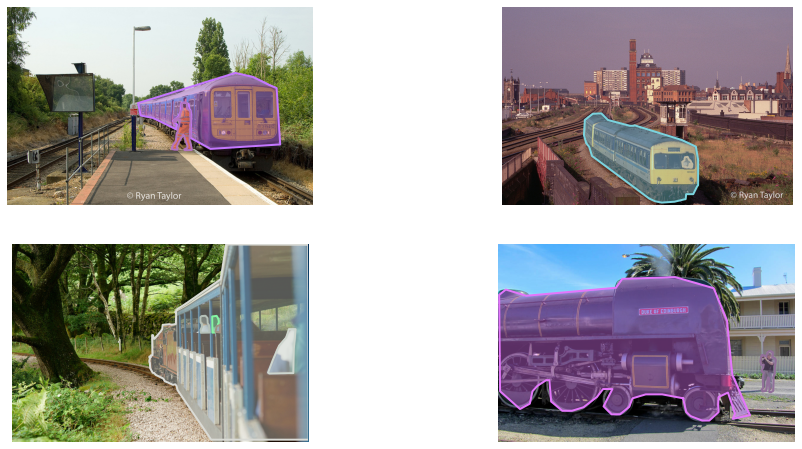

In [279]:
plt_coco(images)

## Semtorch

In [369]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
from albumentations import *
# SemTorch
from semtorch import get_segmentation_learner
from torch.utils.data import Dataset
from pathlib import Path
import random
from sklearn.model_selection import KFold
import numpy as np
import cv2

In [285]:
def img2tensor(img, dtype: np.dtype=np.float32):
    if img.ndim==2 : 
        img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

In [450]:
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            PiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)

In [615]:
class CocoDetection(Dataset):
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        coco_dir (string or Path): Root directory where images are/should be downloaded to.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    
    train_img_mean = np.array([0.65459856,0.48386562,0.69428385])
    train_img_std = np.array([0.15167958,0.23584107,0.13146145])

    def __init__(self, coco_dir, categories = [], year=2017, annotation_type = 'instances', transform=None):
        if isinstance(coco_dir,str):
            coco_dir = Path(coco_dir)
        
        self.coco_dir = coco_dir
        self.categories = categories
        self.catIds = coco.getCatIds(catNms=self.categories)
        self.year = year
        self.annotation_type = annotation_type
        self.transform = transform
        
        self.ann_train, self.ann_val = self.download_annotations()
        self.coco = COCO(self.ann_train)

        images = self.get_imgs()
        img_pth = self.download_coco_images(images)
        self.images = [dict(images[i], path=img_pth[i]) for i in range(len(images))]
        
    def download_annotations(self):
        """Downloads Coco training and validation annotations for given year and type.
        Args:
            coco_dir: Directory where data should be extracted. Will create an annotations
        folder if one doesn't already exists.
            year: should be either 2014 or 2017 depending on desired dataset.
            annotation_type: can be any of instances, keypoints or captions depending on task.
        Returns: PosixPath for training and validation annotation files.
        """
        
        coco_dir = self.coco_dir
        year = self.year
        annotation_type = self.annotation_type

        year = str(year)

        print("checking if annotations already exist...")

        annotation_dir = coco_dir/'annotations'
        if not annotation_dir.is_dir():
            annotation_dir.mkdir()
            print(f"{annotation_dir} directory not found, created it.")

        train_pth_exists = [s for s in annotation_dir.iterdir() if annotation_type+"_train"+year in str(s)]
        val_pth_exists = [s for s in annotation_dir.iterdir() if annotation_type+"_val"+year in str(s)]

        if len(train_pth_exists)>0 and len(val_pth_exists)>0:
            print(f"found annotations for type '{annotation_type}' from {year} COCO dataset on disk")
            print("Done.")
            return train_pth_exists[0],val_pth_exists[0]

        print(f"downloading annotations for type '{annotation_type}' from {year} COCO dataset...")

        resp = urlopen(f'http://images.cocodataset.org/annotations/annotations_trainval{year}.zip')
        zipfile = ZipFile(BytesIO(resp.read()))

        for filename in zipfile.namelist():
            if annotation_type in filename:
                filepath = coco_dir/filename
                print(f"saving annotations to {filepath}")

                if "train" in filename:
                    train_pth = filepath
                elif "val" in filename:
                    val_pth = filepath

                with zipfile.open(filename) as f:
                    data = f.read()
                    d = json.loads(data)
                    with open(filepath, "w") as fout:
                        fout.write(json.dumps(d))

        print("Done.")
        return train_pth, val_pth
    
    def download_coco_images(self, images, nthreads=10):
        store = []
        threads = []
        im_to_dl = []
        
        dest = self.coco_dir/'images'

        print("Checking dest for already existing images...")
        for im in images:
            filepath = dest/im['file_name']
            if filepath.exists():
                store.append(filepath)
            else:
                im_to_dl.append(im)

        if len(im_to_dl)==0:
            print("All images already exist on disk")
            return store

        #threads > 50 will be stale
        if nthreads>50:
            print("setting nthreads to 50 as maximum allowed")
            nthreads=50

        # create the threads
        for i in range(nthreads):
            img_grp = im_to_dl[i::nthreads]
            for im in img_grp:
                t = Thread(target=download_img, 
                           args=(im['coco_url'],im['file_name'],dest,store))
                threads.append(t)

        # start the threads
        print("assigning requests to threads...")
        [t.start() for t in threads]
        # wait for the threads to finish
        print("downloading images..")
        [t.join() for t in tqdm(threads)]

        return store
    
    def plt_coco(self):
        coco = self.coco
        images = self.images
        catIds = self.catIds
        idxs = np.random.randint(len(images),size=4)

        fig = plt.figure()
        for i in range(4):
            im = images[idxs[i]]
            fig.set_size_inches(16, 8)
            ax = fig.add_subplot(2, 2, i+1)
            I = mpimg.imread(im['path'])
            plt.imshow(I); plt.axis('off')

            annIds = coco.getAnnIds([im['id']], catIds, iscrowd=None)
            anns = coco.loadAnns(annIds)
            coco.showAnns(anns)
    
    def get_imgs(self):
        coco = self.coco
        catIds = self.catIds
        imgIds = coco.getImgIds(catIds=catIds)
        return coco.loadImgs(imgIds)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        image = self.images[index]
        img_id = image['id']
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        img = Image.open(image['path']).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(image=img,mask=target)

        return image, target


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.coco_dir)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [616]:
cocodata = CocoDetection(coco_dir,categories=['person','train'])

checking if annotations already exist...
found annotations for type 'instances' from 2017 COCO dataset on disk
Done.
loading annotations into memory...
Done (t=69.53s)
creating index...
index created!
Checking dest for already existing images...
All images already exist on disk


In [617]:
coco_img, coco_mask = cocodata.__getitem__(2)

In [618]:
cocodata.catIds

[1, 7]

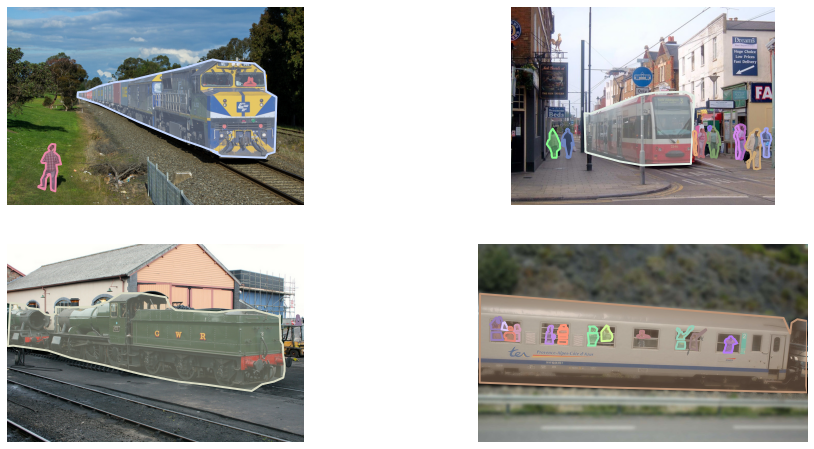

In [619]:
cocodata.plt_coco()

In [367]:
from pycocotools import mask

In [341]:
CAT_LIST = catIds

In [365]:
def transform_tr(sample):
    composed_transforms = transforms.Compose([
        tr.RandomHorizontalFlip(),
        tr.RandomScaleCrop(base_size=self.args.base_size, crop_size=self.args.crop_size),
        tr.RandomGaussianBlur(),
        tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        tr.ToTensor()])

    return composed_transforms(sample)

In [498]:
CAT_LIST

[1, 7]

In [338]:
# def _gen_seg_mask(self, target, h, w):
def _gen_seg_mask(target, h, w):
    im_mask = np.zeros((h, w), dtype=np.uint8)
#     coco_mask = self.coco_mask
    coco_mask = mask
    for instance in target:
        rle = coco_mask.frPyObjects(instance['segmentation'], h, w)
        m = coco_mask.decode(rle)
        cat = instance['category_id']
#         if cat in self.CAT_LIST:
        if cat in CAT_LIST:
#             c = self.CAT_LIST.index(cat)
            c = CAT_LIST.index(cat)
        else:
            continue
        if len(m.shape) < 3:
            im_mask[:, :] += (im_mask == 0) * (m * c)
        else:
            im_mask[:, :] += (im_mask == 0) * (((np.sum(m, axis=2)) > 0) * c).astype(np.uint8)
    return im_mask

In [391]:
def _make_img_gt_point_pair(img, coco_dir):
#     coco = self.coco
#     coco_dir = self.dir
    _img = Image.open(coco_dir/('images/'+img['file_name'])).convert('RGB')
    cocotarget = coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
    _target = Image.fromarray(_gen_seg_mask(
        cocotarget, img['height'], img['width']))

    return _img, _target

In [402]:
def __getitem__(img, coco_dir, split, tfms=None):
    _img, _target = _make_img_gt_point_pair(img, coco_dir)

    if tfms is not None :
        augmented = tfms(image=np.array(_img), mask=np.array(_target))
        return augmented['image'],augmented['mask']
    elif split == 'val':
        return transform_val(sample)

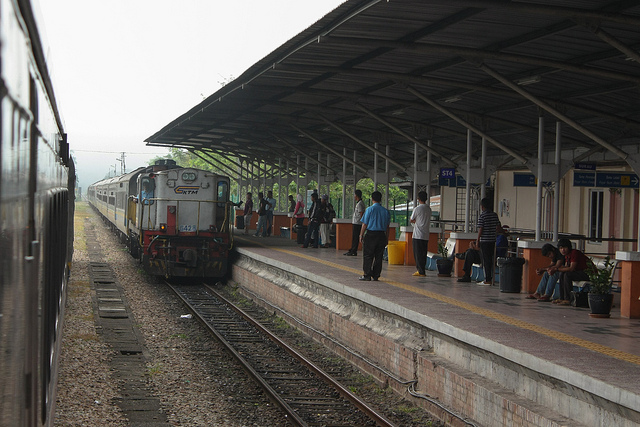

In [451]:
Image.fromarray(np.array(_make_img_gt_point_pair(img,coco_dir)[0]))

In [495]:
aug_im, aug_mask = __getitem__(img, coco_dir, 'train', get_aug())

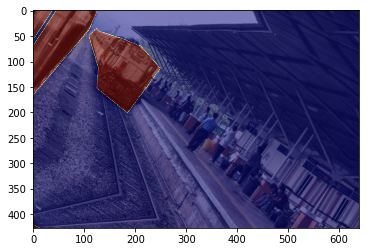

In [496]:
plt.imshow(aug_im)
plt.imshow(aug_mask, cmap='jet', alpha=0.5)

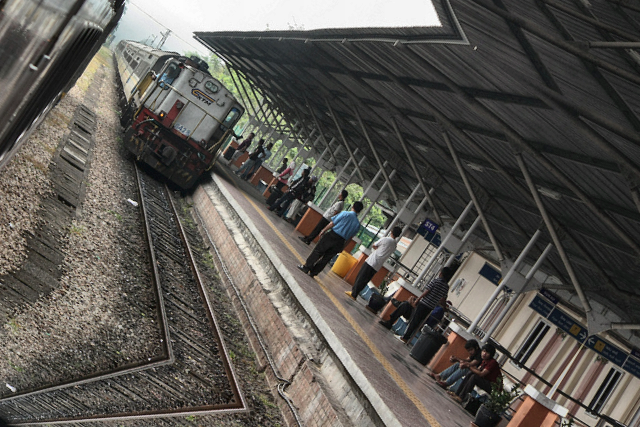

In [497]:
Image.fromarray(aug_im)

In [291]:
I = mpimg.imread(coco_dir/('images/'+img['file_name']))
I

array([[[169, 164, 171],
        [200, 205, 209],
        [213, 223, 225],
        ...,
        [ 15,  17,  16],
        [ 15,  17,  16],
        [ 18,  20,  19]],

       [[167, 162, 169],
        [198, 203, 209],
        [212, 222, 224],
        ...,
        [ 15,  17,  16],
        [ 14,  16,  15],
        [ 15,  17,  16]],

       [[165, 160, 167],
        [197, 202, 208],
        [212, 222, 224],
        ...,
        [ 15,  17,  16],
        [ 16,  18,  17],
        [ 18,  20,  19]],

       ...,

       [[ 81,  73,  62],
        [ 79,  70,  63],
        [ 76,  68,  57],
        ...,
        [135, 127, 116],
        [135, 127, 114],
        [131, 123, 110]],

       [[ 71,  62,  53],
        [ 73,  64,  57],
        [ 77,  69,  58],
        ...,
        [136, 130, 118],
        [137, 131, 117],
        [139, 133, 119]],

       [[ 76,  67,  58],
        [ 73,  64,  57],
        [ 73,  65,  54],
        ...,
        [137, 131, 119],
        [138, 132, 120],
        [146, 140, 128]]

In [309]:
for ann in anns:
    print(coco.annToMask(ann).max())

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [310]:
sum([coco.annToMask(ann) for ann in anns]).max()

2

In [286]:
img2tensor(I)

tensor([[[169., 200., 213.,  ...,  15.,  15.,  18.],
         [167., 198., 212.,  ...,  15.,  14.,  15.],
         [165., 197., 212.,  ...,  15.,  16.,  18.],
         ...,
         [ 81.,  79.,  76.,  ..., 135., 135., 131.],
         [ 71.,  73.,  77.,  ..., 136., 137., 139.],
         [ 76.,  73.,  73.,  ..., 137., 138., 146.]],

        [[164., 205., 223.,  ...,  17.,  17.,  20.],
         [162., 203., 222.,  ...,  17.,  16.,  17.],
         [160., 202., 222.,  ...,  17.,  18.,  20.],
         ...,
         [ 73.,  70.,  68.,  ..., 127., 127., 123.],
         [ 62.,  64.,  69.,  ..., 130., 131., 133.],
         [ 67.,  64.,  65.,  ..., 131., 132., 140.]],

        [[171., 209., 225.,  ...,  16.,  16.,  19.],
         [169., 209., 224.,  ...,  16.,  15.,  16.],
         [167., 208., 224.,  ...,  16.,  17.,  19.],
         ...,
         [ 62.,  63.,  57.,  ..., 116., 114., 110.],
         [ 53.,  57.,  58.,  ..., 118., 117., 119.],
         [ 58.,  57.,  54.,  ..., 119., 120., 128.]]]

In [287]:
coco.annToMask(anns)

TypeError: list indices must be integers or slices, not str

In [289]:
anns[0]

{'segmentation': [[95.96,
   183.27,
   142.01,
   170.8,
   180.4,
   163.12,
   236.05,
   178.48,
   230.29,
   286.91,
   152.57,
   279.23,
   133.38,
   243.73,
   83.48,
   202.47,
   88.28,
   181.36]],
 'area': 13102.567449999999,
 'iscrowd': 0,
 'image_id': 174544,
 'bbox': [83.48, 163.12, 152.57, 123.79],
 'category_id': 7,
 'id': 170263}

In [157]:
mask = coco.annToMask(anns[0])
# for i in range(len(anns)):
#     mask += coco.annToMask(anns[i])
plt.imshow(mask)

In [ ]:
def map_source_class_id(self, source_class_id):
    """Takes a source class ID and returns the int class ID assigned to it.
    For example:
    dataset.map_source_class_id("coco.12") -> 23
    """
    return self.class_from_source_map[source_class_id]

def load_mask(self, image_id):
    """Load instance masks for the given image.
    Different datasets use different ways to store masks. This
    function converts the different mask format to one format
    in the form of a bitmap [height, width, instances].
    Returns:
    masks: A bool array of shape [height, width, instance count] with
        one mask per instance.
    class_ids: a 1D array of class IDs of the instance masks.
    """
    # If not a COCO image, delegate to parent class.
    image_info = self.image_info[image_id]
    if image_info["source"] != "coco":
        return super(CocoDataset, self).load_mask(image_id)

    instance_masks = []
    class_ids = []
    annotations = self.image_info[image_id]["annotations"]
    # Build mask of shape [height, width, instance_count] and list
    # of class IDs that correspond to each channel of the mask.
    for annotation in annotations:
        class_id = self.map_source_class_id(
            "coco.{}".format(annotation['category_id']))
        if class_id:
            m = self.annToMask(annotation, image_info["height"],
                               image_info["width"])
            # Some objects are so small that they're less than 1 pixel area
            # and end up rounded out. Skip those objects.
            if m.max() < 1:
                continue
            # Is it a crowd? If so, use a negative class ID.
            if annotation['iscrowd']:
                # Use negative class ID for crowds
                class_id *= -1
                # For crowd masks, annToMask() sometimes returns a mask
                # smaller than the given dimensions. If so, resize it.
                if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                    m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
            instance_masks.append(m)
            class_ids.append(class_id)

    # Pack instance masks into an array
    if class_ids:
        mask = np.stack(instance_masks, axis=2)
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids
    else:
        # Call super class to return an empty mask
        return super(CocoDataset, self).load_mask(image_id)

def annToRLE(self, ann, height, width):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    segm = ann['segmentation']
    if isinstance(segm, list):
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, height, width)
        rle = maskUtils.merge(rles)
    elif isinstance(segm['counts'], list):
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, height, width)
    else:
        # rle
        rle = ann['segmentation']
    return rle

def annToMask(self, ann, height, width):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = self.annToRLE(ann, height, width)
    m = maskUtils.decode(rle)
    return m